# UTinvert: A workflow for performing rigorous surface-wave inversion.

> Joseph P. Vantassel, The University of Texas at Austin

## About UTinvert

`UTinvert` is the name given to a systematic procedure for inverting surface-wave dispersion data that attempts to rigorously address the inverse problem's non-linearity and non-uniqueness. The workflow was developed by Joseph P. Vantassel under the supervision of Brady R. Cox at the University of Texas at Austin. The recommendations with their justifications are summarized in the below journal paper, which we ask that you please cite if you use this notebook or `swipp` in your research.

>Citation Forthcoming

## About `swipp`

`swipp` is the engine behind the `UTinvert` workflow which allows for rapid `s`urface `w`ave `i`nversion `p`re- and `p`ost-processing. This notebook is __an__ example of an inversion workflow that can be built using `swipp`. More information about `swipp` can be found [here](https://github.com/jpvantassel/swipp). This notebook and `swipp` was built and is maintained by Joseph P. Vantassel, under the supervision of Brady R. Cox at the University of Texas at Austin.

## About this notebook

This notebook has four parts:

1. [Defining the inversion target](#Defining-the-Inversion-Target)
2. [Selecting the inversion parameterizations](#Selecting-the-Inversion-Parameterizations)
3. [Running the inversion](#Running-the-Inversion)
4. [Post-processing the inversion results](#Post-processing-the-Inversion-Results)

__This notebook is intended as a convenient tool to expedite surface-wave inversion, however it is paramount that the user have some working knowledge of surface-wave inverison to be able to understand the inversio process and extract meaningful results__.

All the best,

\- Joe

In [1]:
import swipp
import numpy as np
# import pandas as pd
import matplotlib.pyplot as plt
import csv, glob, re, os, shutil
import ipywidgets as widgets

def plotter(tar):
    fig, axs = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(6,3), dpi=150)
    tar.plot(x="frequency", y="velocity", ax=axs[0])
    tar.plot(x="wavelength", y="velocity", ax=axs[1])
    axs[1].legend()
    
def on_button_click(*args, **kwargs):
    global tar
    click.clear_output()
    button.description = 'Plotting'
    with click:
        if tar.is_no_velstd():
            tar.setcov(ecov.value)
        else:
            tar.setmincov(ecov.value)
        plotter(tar)
        button.description = 'Done'

def change_options(*args):
    global tar
    tar=swipp.Target.from_csv(fname.value)
    if tar.is_no_velstd(): # If Vel_std does not exist -> prompt for COV
        ecov.description = 'COV:'
        ecov.options = {'COV=0.05':0.05,'COV=0.075':0.075,'COV=0.1':0.1}
    else: # If Vel_std exists -> continue all is good
        ecov.description = 'Min COV:'
        ecov.options = {'Provided':0, 'COV=0.05':0.05,'COV=0.075':0.075,'COV=0.1':0.1}

# def plotPseudoVs(tar, vslimits=None, axis=None):
#     plt.figure(num=2, figsize=(5,8))
#     if axis!=None: # Handle kwarg if specific axis is entered
#         plt.axis(axis)
#     plt.plot(tar.pseudo()[0],tar.pseudo()[1],'*k')
#     plt.gca().invert_yaxis(); plt.xlabel('Pseudo-Shear Wave Velocity, Vs (m/s)')
#     plt.ylabel('Pseudo-Depth (m)')
#     plt.grid(which='both')
#     if vslimits !=None: # If upper and lower Vs limits are given plot them
#         plt.plot([vslimits[0],vslimits[0]],[ymin,ymax],'--g')
#         plt.plot([vslimits[1],vslimits[1]],[ymin,ymax],'--r')
#     plt.show()
    
# def updatePlot(sxMin,sxMax,syMin,syMax,svMin,svMax):
#     plotPseudoVs(tar,vslimits=[svMin,svMax],axis=[sxMin,sxMax,syMin,syMax])
    
# def onUpdate(*args, **kwargs):
#     click.clear_output()
#     updateButton.description='Update'
#     with click:
#         plt.close(fig='all')
#         updatePlot(xMin.value,xMax.value,yMin.value,yMax.value,vMin.value,vMax.value)

# def onHome(*args, **kwargs):
#     click.clear_output()
#     with click:
#         plt.close(fig='all')
#         updatePlot(xmin,xmax,ymin,ymax,vMin.value,vMax.value)

## Defining the Inversion Target

### Importing the Experimental Dispersion Data

1. Use the left dropdown menu to select the file with your experimental disperison data.
2. If no uncertainty is provided use the right dropdown menu to select an appropraite coefficient of variation (COV).
3. Press `Load` when ready.
4. Review the figure to ensure your data has loaded correctly, then proceed to the next cell.

[Back to top](#About-this-notebook)

Output()

Output()

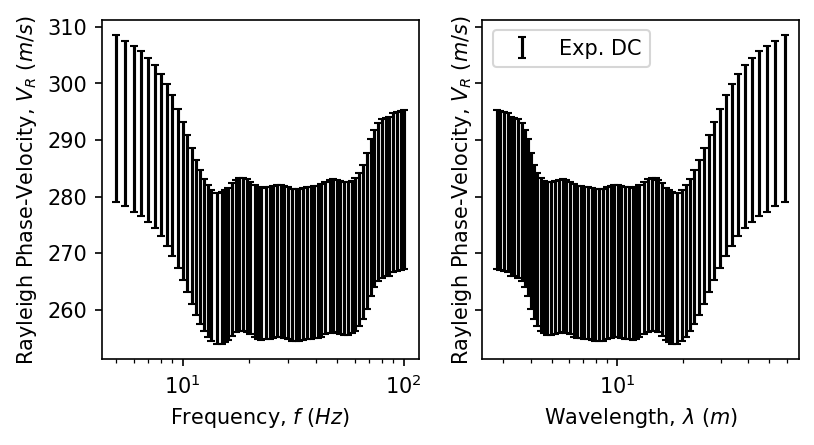

In [2]:
csvs = glob.glob('*.csv')                                                                 # Return list of .csv in current dir
init = widgets.Output()                                                                        # Create container for output
fname = widgets.Dropdown(options=['Select Experimental Dispersion Data File'] + csvs,
                        description='File Name:')                                              # Dropdown for filename
ecov=widgets.Dropdown(options={' ':None}, description='COV')                                   # Drop down for COV
button=widgets.Button(description='Load')                                                      # Button to plot
fname.observe(change_options,names='value'); display(init)                                     # Observe filename respond with COV accordingly
ui=widgets.HBox(children=[fname, ecov, button])                                                # Box up widgets to make it nice
click = widgets.Output(); button.on_click(on_button_click); display(ui,click)                  # Look for click and return output (b/c of JupyterLab)

### Resampling the Experimental Disperison

1. Select the domain in which you wish to resample. _Wavelength is recommended._
2. Select whether you want to resample in log or linear space. _Log is recommended._
3. Select the `minimum`, `maximum`, and `number` of points. _20-30 points are recommended._
4. Press `Load` after making your selections.
4. Review the figure to ensure your data has been resampled correctly, then proceed to the next cell.

[Back to top](#About-this-notebook)

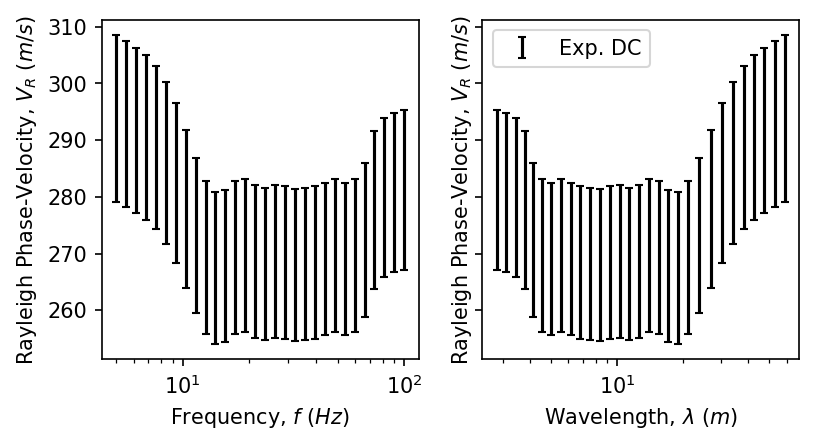

In [3]:
domain = 'frequency'
res_type = 'log'
pmin = 5
pmax = 100
pn = 30

tar.resample(pmin=pmin, pmax=pmax, pn=pn, res_type=res_type, domain=domain, inplace=True)

# msg = "Please clear out contents of directory"
# os.mkdir("Targets/") if os.path.isdir("Targets/")==False else print(msg+" Targets before continuing.")
if os.path.isdir("Targets/")==False:
    os.mkdir("Targets/")
tar.to_target("Targets/Tar01", version="2")

plotter(tar)

## Selecting the Inversion Parameterizations

1. Enter upper and lower limits for `vp`, `vs`, `Poisson's Ratio`, and `mass density`. 
2. Select the number of Layering Ratio or Layering by Number inversions you would like to consider, use `ctrl+click` to select multiple.
3. Review your selections, then proceed to and run the next cell.
 
__Be cautious when performing your selections as they can strongly bias your inversion's final result if not done properly!__
 
[Back to top](#About-this-notebook)

In [4]:
vpstep = 100
vpMin = widgets.FloatText(value=100, step=vpstep, description=r'\(V_{p,min} (m/s)\)')
vpMax = widgets.FloatText(value=2500, step=vpstep, description=r'\(V_{p,max} (m/s)\)')
vpRev = widgets.Checkbox(value=True,description='No Vp Reversal')

vstep = 50
vMin = widgets.FloatText(value=round(min(tar.velocity)*0.9,0), step=vstep, description=r'\(V_{s,min} (m/s)\)')
vMax = widgets.FloatText(value=round(max(tar.velocity)*1.1,0), step=vstep, description=r'\(V_{s,max} (m/s)\)')
vRev = widgets.Checkbox(value=True,description='No Vs Reversal')

nustep = 0.05
nuMin = widgets.FloatText(value=0.15, step=nustep, description=r'\(\nu_{min}\)')
nuMax = widgets.FloatText(value=0.5, step=nustep, description=r'\(\nu_{max}\)')
nuRev = widgets.Checkbox(value=True,description='No PR Increase')

rhstep = 0.05
rhMin = widgets.FloatText(value=2000, step=rhstep, description=r'\(\rho_{min} (kg/m^{3})\)')
rhMax = widgets.FloatText(value=2500, step=rhstep, description=r'\(\rho_{max} (kg/m^{3})\)')
rhRev = widgets.Checkbox(value=True,description='No Rho Decrease')

hvstep = 0.01
ellMean = widgets.FloatText(value=None, step=hvstep, description=r'\(f_{0, H/V}\)')
ellStd = widgets.FloatText(value=None, step=nustep, description=r'\(\sigma_{0, H/V}\)')
useEll= widgets.Checkbox(value=False,description='Use H/V Peak')

LRs = widgets.SelectMultiple(description='By Ratio (' + r'\(\Xi\)' + ')', 
                             options=[('LR: 1.2',1.2), ('LR: 1.3',1.3), ('LR: 1.5',1.5), ('LR: 2.0',2.0), ('LR: 2.5',2.5),
                                      ('LR: 3.0',3.0), ('LR: 3.5',3.5), ('LR: 5.0',5.0), ('LR: 6.0',6.0), ('LR: 7.0',7.0)],
                             layout=widgets.Layout(height='200px'))
LNs = widgets.SelectMultiple(description='By Number', 
                             options=[('LN: 3',3),('LN: 4',4),('LN: 5',5),
                                      ('LN: 6',6),('LN: 7',7),('LN: 8',8),('LN: 9',9),
                                      ('LN: 10',10), ('LN: 15',15), ('LN: 20',20),],
                             layout=widgets.Layout(height='200px'))

Vs = widgets.VBox([vMin, vMax, vRev])
Vp = widgets.VBox([vpMin, vpMax, vpRev])
Nu = widgets.VBox([nuMin, nuMax, nuRev])
Rh = widgets.VBox([rhMin, rhMax, rhRev])
ui_new = widgets.VBox([widgets.HBox([Vp, Nu]), widgets.HBox([Vs, Rh]), widgets.HBox([LRs, LNs])])
display(ui_new)

### Write Parameterizations to Disk

[Back to top](#About-this-notebook)

In [5]:
#  msg = "Please clear out contents of directory"
# os.mkdir("Params/") if os.path.isdir("Params/")==False else print(msg+" Params before continuing.")
if os.path.isdir("Params/")==False:
    os.mkdir("Params/")
    
wmin, wmax = min(tar.wavelength), max(tar.wavelength)
rh = swipp.Parameter.from_fx(2000)
pr = swipp.Parameter.from_ln(wmin=wmin, wmax=wmax, nlayers=1, par_min=nuMin.value, par_max=nuMax.value, par_rev=nuRev.value)
vp = swipp.Parameter.from_ln(wmin=wmin, wmax=wmax, nlayers=3, par_min=vpMin.value, par_max=vpMax.value, par_rev=vpRev.value)

# Layering by Number
for ln in LNs.value:
    vs = swipp.Parameter.from_ln(wmin=wmin, wmax=wmax, nlayers=ln, par_min=vMin.value, par_max=vMax.value, par_rev=vRev.value)
    par=swipp.Parameterization(vp=vp, pr=pr, vs=vs, rh=rh)
    par.to_param(f"Params/LN{ln}", version="2")
    
# Fixed-Thickness Layers
dmax=20
for ftl in [10, 20]:
    vs = swipp.Parameter.from_ftl(nlayers=ftl, thickness=dmax/ftl, par_min=vMin.value, par_max=vMax.value, par_rev=vRev.value)
    par=swipp.Parameterization(vp=vp, pr=pr, vs=vs, rh=rh)
    par.to_param(f"Params/FTL{ftl}",version="2")

## Running the Inversion

Forthcoming!

[Back to top](#About-this-notebook)

In [ ]:
# from agavepy.agave import Agave
# from agavepy.async import AgaveAsyncResponse
# ag=Agave.restore()

# jobid = "QuakeCOre"
# runtime = "00:01:00"
# nameoftrial = "Example"
# seednumber = "2"
# initialrandsample = "100"
# numberofiterations = "50"
# numberperiteration = "50"
# numberperresampling = "50"
# numberofprofiles = "100"
# fpoints = "25"
# fmin = "1"
# fmax = "50"

# full=%pwd
# usr=ag.profiles.get()["username"]
# shrt=full[20::]
# job_description = {
#     "jobName":jobid,
#     "appId":"GeopsyInvert-1.0.0",
#     "executionSystem":"designsafe.community.exec.stampede2.nores",
#     "batchQueue":"normal",
#     "nodeCount":1,
#     "processorsPerNode":1,
#     "maxRunTime":runtime,
#     "archive":True,
#     "retries":0,
#     "inputs":{
#         "workingDirectory":"agave://designsafe.storage.default/"+usr+shrt
#     },
#     "parameters":{
#       "Nm":nameoftrial,
#       "Sd":seednumber,
#       "N0":initialrandsample,
#       "It":numberofiterations,
#       "Ns":numberperiteration,
#       "Nr":numberperresampling,
#       "Np":numberofprofiles,
#       "Fnum":fpoints,
#       "Fmin":fmin,
#       "Fmax":fmax,
#     }
# }
# display(job_description)
# job = ag.jobs.submit(body=job_description)
# asrp = AgaveAsyncResponse(ag, job)

## Post-processing the Inversion Results

[Back to top](#About-this-notebook)

### Importing the Data

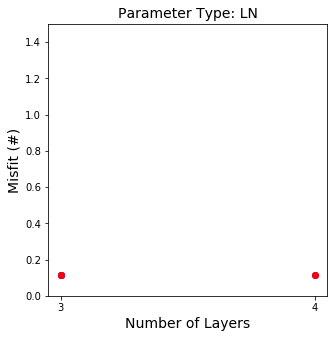

In [19]:
ndc = 1            # Number of dispersion curves, may use "all"
nrayleigh = 1      # Number of rayleigh modes, may use "all"
nlove = 0          # Number of love modes, may use "all"
ngm = 1            # Number of ground models, may use "all"

fnames = glob.glob('Text/*_DC.txt')
fnames.sort(key=lambda x: int(re.findall(r".*[\\/].*_.*[LF][TRN][IL]?(\d+)_Sd\d+_DC.txt$",x)[0]))

dcs, gms = {}, {}
for fname in fnames:
    filename, partype, parnumber, seed = re.findall(r".*[\\/](.*_.*([LF][TRN][IL]?)(\d+)_Sd(\d+)_DC.txt)$", fname)[0]
    
    # Divide LR by 10
    if partype in ['LR']:
        parnumber = str(int(parnumber)/10)
    
    # Save by parameterization
    if partype not in dcs.keys():
        dcs.update({partype:{}})
        gms.update({partype:{}})
        firstpass = True
        
    # Save by parameterization number        
    if parnumber not in dcs[partype].keys():
        dcs[partype].update({parnumber:{}})
        gms[partype].update({parnumber:{}})
        
    # Save by seed
    dcs[partype][parnumber].update({seed:swipp.DispersionSuite.from_geopsy(fname=fname, ndc=ndc, 
                                                                           nrayleigh=nrayleigh, nlove=nlove)})
    gms[partype][parnumber].update({seed:swipp.GroundModelSuite.from_geopsy(fname=fname[:-6]+"GM.txt", nmodels=ngm)})
    
    
ncols = len(list(dcs.keys()))
fig, axs = plt.subplots(nrows=1, ncols=ncols, figsize=(5*ncols,5))
axs = [axs] if type(axs) != list else axs
bestseed = {}
for ax, partype in zip(axs, dcs):
    bestseed.update({partype:{}})
    for parnumber in dcs[partype]:
        seeds, misfits = [], []
        for seed in dcs[partype][parnumber].keys():
            seeds.append(seed)
            misfits += dcs[partype][parnumber][seed].misfits
            ax.plot(parnumber, misfits[-1], 'bo')
        bestseed[partype].update({parnumber:seeds[misfits.index(min(misfits))]})
        ax.plot(parnumber, min(misfits),'ro')
        ax.set_ylim((0,1.5))
        ax.set_ylabel('Misfit (#)', fontsize=14)
        ax.set_xlabel('Number of Layers', fontsize=14)
        ax.set_title("Parameter Type: "+partype, fontsize=14)
plt.show()

### General Settings

In [20]:
colors = ["#588c7e","#e6c833","#f2ae72","#e97816","#a366ff"]

### Plotting Dispersion

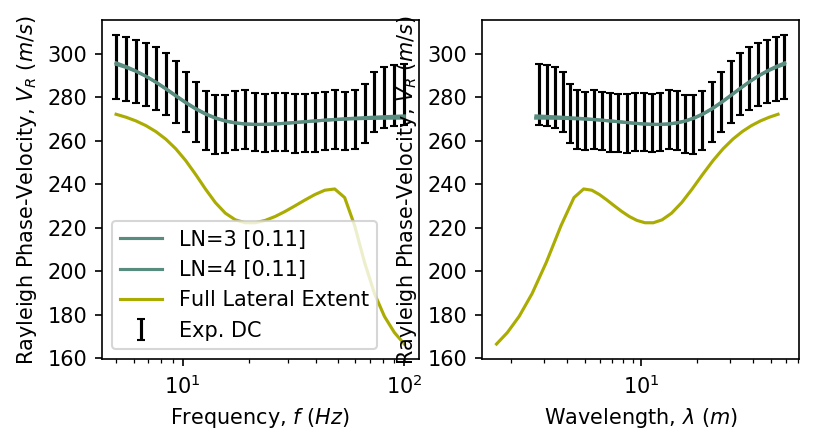

In [41]:
ndc = 1       # Number of "best" dispersion curves to plot, may use "all".
nray = 1      # Number of Rayleigh-wave modes to plot, may use "all".
# nlov = 0      # Number of Love-wave modes to plot, may use "all".

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(6,3), dpi=150)

# Plot the Theoretical Modes
for partype, color in zip(dcs, colors):
    for parnumber in dcs[partype]:
        best = bestseed[partype][parnumber]
        suite = dcs[partype][parnumber][best]
        
        for dc_count, dcset in enumerate(suite):
            
            misfits = dcs[partype][parnumber][best].misfits
            if len(misfits)==1:
                misfit_txt = f"{round(misfits[0],2)}"
            else:
                misfit_txt = f"{round(misfits[0],2)}-{round(misfits[ndc],2)}"
            label = f"{partype}={parnumber} [{misfit_txt}]"
            
            for mode in range(nray):
                try:
                    dc = dcset.rayleigh[mode]
                    axs[0].plot(dc.frequency, dc.velocity, color=color, label=label)
                    label=None
                    axs[1].plot(dc.wavelength, dc.velocity, color=color, label=label)
                except KeyError:
                    print(f"Could not find mode {mode}.")
                    
            if dc_count+1 == ndc:
                break
                
# Plot the Theoretical Modes of the True Solution
nray = 1      # Number of Rayleigh-wave modes to plot, may use "all".
nlov = 0      # Number of Love-wave modes to plot, may use "all".
true = swipp.DispersionSet.from_geopsy(fname="output.txt", nrayleigh=nray, nlove=nlov)
color = "#abac02"

label = f"Full Lateral Extent"
for mode, dc in true.rayleigh.items():
    axs[0].plot(dc.frequency, dc.velocity, color=color, label=label)
    label=None
    axs[1].plot(dc.wavelength, dc.velocity, color=color, label=label)
    
ax = axs[0]
tar.plot(ax=ax)
ax.legend()

ax = axs[1]
tar.plot(ax=ax, x="wavelength")

plt.show()

### Plotting Vs

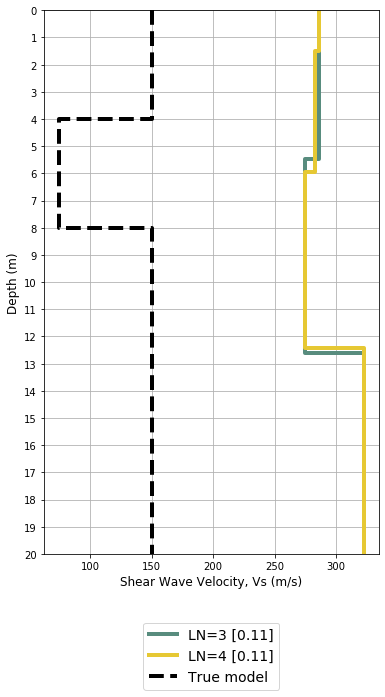

In [45]:
# True Profile
tk=[4,4,0]          # Thickness (m)
vs=[150,75,150]     # Shear-wave velocity (m/s)
vp=[300,150,300]    # Compression-wave velocity (m/s)
rh=[2000]*3         # Mass density (kg/m3)

true=swipp.GroundModel(thickness=tk, vp=vp, vs=vs, density=rh)

# Plotting
npars = len(dcs.keys())
fig, axs = plt.subplots(nrows=1, ncols=npars, sharey=True, sharex=True, figsize=(6*npars,10))
axs = [axs] if type(axs) != list else axs
for partype, ax in zip(gms, axs):
    

                
    for parnumber, color in zip(gms[partype], colors):
        
        
        best = bestseed[partype][parnumber]
        suite = gms[partype][parnumber][best]
        
        misfits = dcs[partype][parnumber][best].misfits
        if len(misfits)==1:
            misfit_txt = f"{round(misfits[0],2)}"
        else:
            misfit_txt = f"{round(misfits[0],2)}-{round(misfits[ndc],2)}"
        label = f"{partype}={parnumber} [{misfit_txt}]"
            
        gm = suite[0]
        
        ax.plot(gm.vs2, gm.depth, color=color, linewidth=4, label=label)
        
    ax.plot(true.vs2, true.depth,
            color='black', linestyle='dashed', linewidth = 4,
            label='True model')
    ax.set_ylim([20,0])
    ax.set_xlabel('Shear Wave Velocity, Vs (m/s)', fontsize=12)
    ax.set_ylabel('Depth (m)', fontsize=12)
    ax.grid(which='both')
    ax.legend(fontsize=14, bbox_to_anchor=(0.5, -0.25), loc='lower center', borderaxespad=0.)
    ax.set_yticks(np.arange(0, 21, 1))

plt.show()

## Percent Difference

TODO (jpv): Leaving this off for now.

In [ ]:
#Plot percent difference
dy = 0.05
plt.figure(figsize=(6,10))
for partype, fmt in zip(gms, ('-','--',':')):
    for parnumber, color in zip(gms[partype], colors):
        best = bestseed[partype][parnumber]
        plt.plot((np.array(utinvert.GM(gms[partype][parnumber][best].select()).gm2_disc(20,dy=dy,param='vs')[1])-np.array(true.gm2_disc(20,dy=dy,param='vs')[1]))/np.array(true.gm2_disc(20,dy=dy,param='vs')[1])*100,
                 np.array(utinvert.GM(gms[partype][parnumber][best].select()).gm2_disc(20,dy=dy,param='depth')[0]),
                 linewidth=4,
                 label=partype + "=" + parnumber + "[" + str(dcs[partype][parnumber][best].misfit()[0])[0:5] + "]"
                )
        
#plt.plot((np.interp(disctrue_depth, pdepth3[::-1], pVs3[::-1]) - disctrue_vs)/disctrue_vs*100,disctrue_depth, linewidth=4,label='Depth factor = 3.0')
        
plt.axis([-200,400, 20, 0])
plt.yticks(np.arange(0, 21, 1))
plt.xlabel('Percent Difference (%)',fontsize=16)
plt.ylabel('Depth (m)',fontsize=16)
plt.grid(which='both')
plt.plot([-200,10000],[thick[0],thick[0]],'k--')
plt.plot([-200,10000],[thick[0]+thick[1],thick[0]+thick[1]],'k--')
plt.plot([0,0],[0,20],linewidth=2,color='k')
plt.legend(fontsize=16,bbox_to_anchor=(1.65, 0),loc='lower right',borderaxespad=0.)
plt.show()